In [32]:
from concurrent.futures import ThreadPoolExecutor

import geopandas as gpd
import numpy as np
import odc.geo
from odc.stac import load
from pystac_client import Client
from shapely import geometry
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

import datacube
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

import sys, os
sys.path.insert(1, os.path.abspath('../Tools'))

import rasterio
import matplotlib
import pickle
import joblib
from utils import load_data, predict_xr

In [33]:
%reload_ext autoreload
%autoreload 2

## Find and load data

Load data and set up your array to use for prediction

In [34]:
# Configure some things up front
chunks = dict(x=2048, y=2048)
datetime = "2020"

bbox = [177.442236,-17.782827, 177.590031,-17.696239]
bbox_geometry = geometry.box(*bbox)

gdf = gpd.GeoDataFrame({'geometry': [bbox_geometry]}, crs='EPSG:4326')
gdf.explore()

In [35]:
merged = load_data(bbox, datetime=datetime, chunks=chunks, resolution=10)
merged

<xarray.Dataset>
Dimensions:      (y: 1007, x: 1646)
Coordinates:
  * y            (y) float64 -1.989e+06 -1.989e+06 ... -1.999e+06 -1.999e+06
  * x            (x) float64 3.055e+06 3.055e+06 ... 3.071e+06 3.071e+06
    spatial_ref  int32 3832
    time         datetime64[ns] 2020-01-01
Data variables: (12/24)
    B02          (y, x) float32 dask.array<chunksize=(1007, 1646), meta=np.ndarray>
    B03          (y, x) float32 dask.array<chunksize=(1007, 1646), meta=np.ndarray>
    B04          (y, x) float32 dask.array<chunksize=(1007, 1646), meta=np.ndarray>
    B05          (y, x) float32 dask.array<chunksize=(1007, 1646), meta=np.ndarray>
    B06          (y, x) float32 dask.array<chunksize=(1007, 1646), meta=np.ndarray>
    B07          (y, x) float32 dask.array<chunksize=(1007, 1646), meta=np.ndarray>
    ...           ...
    ndmi         (y, x) float32 dask.array<chunksize=(1007, 1646), meta=np.ndarray>
    ndbi         (y, x) float32 dask.array<chunksize=(1007, 1646), meta=np.ndarray>
    elevation    (y, x) float32 dask.array<chunksize=(1007, 1646), meta=np.ndarray>
    mean_vv      (y, x) float32 dask.array<chunksize=(1007, 1646), meta=np.ndarray>
    mean_vh      (y, x) float32 dask.array<chunksize=(1007, 1646), meta=np.ndarray>
    mean_vv_vh   (y, x) float32 dask.array<chunksize=(1007, 1646), meta=np.ndarray>

In [36]:
loaded_model = joblib.load("test_model.dump")

In [37]:
loaded_data = merged.compute()

## Run ML classifier

In [38]:
filled = loaded_data.fillna(-9999.0)

In [39]:
# This runs the actual prediction
predicted = predict_xr(loaded_model, filled, proba=True)

# Convert to int
cleaned_predictions = predicted.copy(deep=True)
cleaned_predictions.predictions.data = predicted.predictions.data.astype(np.int8)
cleaned_predictions.probabilities.data = predicted.probabilities.data.astype(np.float32)

cleaned_predictions = cleaned_predictions.rename({"predictions": "lulc", "probabilities": "prob"})

predicting...
   probabilities...


In [40]:
cleaned_predictions

<xarray.Dataset>
Dimensions:      (x: 1646, y: 1007)
Coordinates:
  * x            (x) float64 3.055e+06 3.055e+06 ... 3.071e+06 3.071e+06
  * y            (y) float64 -1.989e+06 -1.989e+06 ... -1.999e+06 -1.999e+06
    spatial_ref  int32 3832
Data variables:
    lulc         (y, x) int8 8 5 5 1 1 3 3 3 3 3 3 3 ... 4 4 4 4 4 4 4 4 4 4 2 2
    prob         (y, x) float32 37.55 35.55 32.43 35.07 ... 72.33 57.48 71.61
Attributes:
    grid_mapping:  spatial_ref

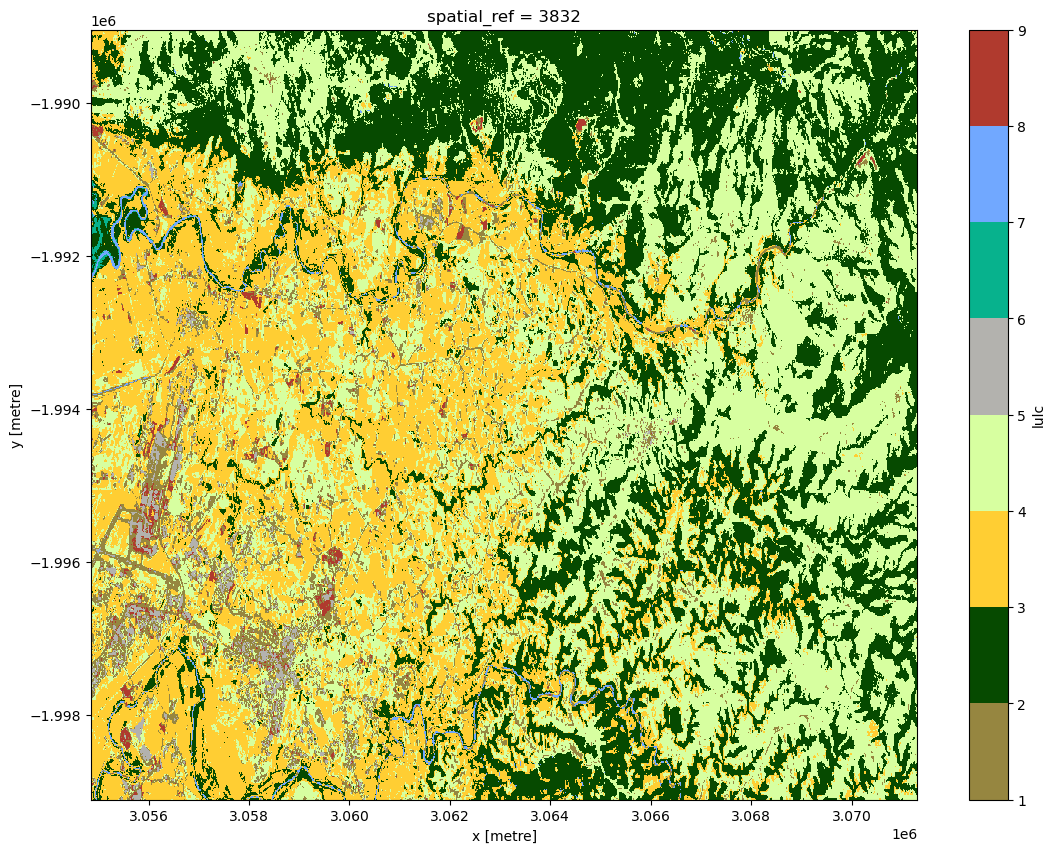

In [41]:
from matplotlib import colors

classes = [
    [1, "bare_land", "#968640"],
    [2, "forest", "#064a00"],
    [3, "crops", "#ffce33"],
    [4, "grassland", "#d7ffa0"],
    [5, "settlements", "#b3b2ae"],
    [6, "mangroves", "#07b28d"],
    [7, "water", "#71a8ff"],
    [8, "quarry", "#b03a2e"]
]

values_list = [c[0] for c in classes]
color_list = [c[2] for c in classes]

# Build a listed colormap.
c_map = colors.ListedColormap(color_list)
bounds = values_list + [9]
norm = colors.BoundaryNorm(bounds, c_map.N)

cleaned_predictions.lulc.plot.imshow(cmap=c_map, norm=norm, size=10)

In [42]:
# Write GeoTIFF
cleaned_predictions.lulc.odc.write_cog("lulc_2020.tif", overwrite=True)

PosixPath('lulc_2020.tif')

In [43]:
cleaned_predictions

<xarray.Dataset>
Dimensions:      (x: 1646, y: 1007)
Coordinates:
  * x            (x) float64 3.055e+06 3.055e+06 ... 3.071e+06 3.071e+06
  * y            (y) float64 -1.989e+06 -1.989e+06 ... -1.999e+06 -1.999e+06
    spatial_ref  int32 3832
Data variables:
    lulc         (y, x) int8 8 5 5 1 1 3 3 3 3 3 3 3 ... 4 4 4 4 4 4 4 4 4 4 2 2
    prob         (y, x) float32 37.55 35.55 32.43 35.07 ... 72.33 57.48 71.61
Attributes:
    grid_mapping:  spatial_ref

In [44]:
quarry_2020 = cleaned_predictions.lulc.isin([8])
quarry_2020 = quarry_2020.astype(np.int32)
quarry_2020.odc.write_cog("Test_change_detection/quarry_2020.tif", overwrite=True)
bareland_2020 = cleaned_predictions.lulc.isin([1])
bareland_2020 = bareland_2020.astype(np.int32)
bareland_2020.odc.write_cog("Test_change_detection/bareland_2020.tif", overwrite=True)

PosixPath('Test_change_detection/bareland_2020.tif')

In [45]:
quarry_2020 = xr.open_dataset("Test_change_detection/quarry_2020.tif")
bareland_2020 = xr.open_dataset("Test_change_detection/bareland_2020.tif")

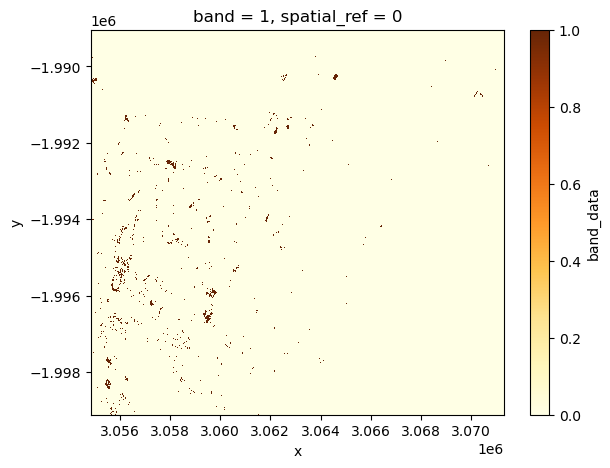

In [46]:
quarry_2020.band_data.plot(cmap="YlOrBr", size=5)

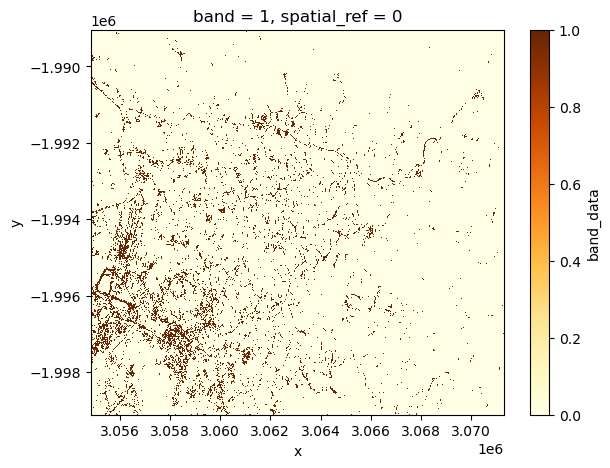

In [47]:
bareland_2020.band_data.plot(cmap="YlOrBr", size=5)